In [1]:
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset
import math
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from StockDataWrapper import get_time_series

In [2]:
class VariableLengthDataset(Dataset):
    def __init__(self, tickers: list[str], data_dir: str, lag_days: int, test_days: int, test: bool):
        self.X = []
        self.y = []
        self.tickers = []

        num_to_ticker = dict()
        ticker_to_num = dict()
        ids = np.linspace(-1, 1, len(tickers)).round(5)
        for i, num in enumerate(ids):
            num_to_ticker[str(num)] = tickers[i]
            ticker_to_num[tickers[i]] = num

        # get the unix timestamp value for 2024-04-15. Used to scale the date value used as input to the model
        cur_unix_timestamp = datetime.datetime(year=2024, month=4, day=15).timestamp()

        for ticker in tickers:
            ordered_time_series = get_time_series(ticker, data_dir, normalize=True)

            if test:
                idx = range(len(ordered_time_series) - lag_days - test_days, len(ordered_time_series))
            else:
                idx = range(lag_days, len(ordered_time_series) - lag_days - test_days)

            # need to get lag_days days of input tokens and predict the lag_days+1 day, and so on
            for cur_target_idx in idx:

                # get target values
                cur_target_actual_after = [ticker_to_num[ticker]]
                for key in ordered_time_series[cur_target_idx]:

                    val = ordered_time_series[cur_target_idx][key]
                    if key == 'date':
                        val = (datetime.datetime.strptime(val, "%Y-%m-%d").timestamp()) / cur_unix_timestamp  # scale to small value
                    cur_target_actual_after.append(val)

                # each "sample" (input) will have multiple tokens. Each token is a vector of the day's values
                cur_input = []

                for i in range(cur_target_idx - lag_days, cur_target_idx):

                    cur_token = [ticker_to_num[ticker]]
                    for key in ordered_time_series[cur_target_idx]:

                        val = ordered_time_series[cur_target_idx][key]
                        if key == 'date':
                            val = (datetime.datetime.strptime(val, "%Y-%m-%d").timestamp()) / cur_unix_timestamp  # scale to small value
                        cur_token.append(val)

                    cur_input.append(cur_token)

                self.X.append(cur_input)
                self.y.append(cur_target_actual_after)
                self.tickers.append(ticker)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32), self.tickers[idx]
    

class IncrementalDataset(Dataset):
    def __init__(self, tickers: list[str], data_dir: str, lag_days: int, test_days: int, test: bool):
        self.X = []
        self.y = []
        self.tickers = []

        num_to_ticker = dict()
        ticker_to_num = dict()
        ids = np.linspace(-1, 1, len(tickers)).round(5)
        for i, num in enumerate(ids):
            num_to_ticker[str(num)] = tickers[i]
            ticker_to_num[tickers[i]] = num

        # get the unix timestamp value for 2024-04-15. Used to scale the date value used as input to the model
        cur_unix_timestamp = datetime.datetime(year=2024, month=4, day=15).timestamp()

        for ticker in tickers:
            ordered_time_series = get_time_series(ticker, data_dir, normalize=True)

            if test:
                idx = range(len(ordered_time_series) - lag_days - test_days, len(ordered_time_series) - lag_days - test_days + 1)
            else:
                idx = range(lag_days, len(ordered_time_series) - lag_days - test_days)

            # need to get lag_days days of input tokens and predict the lag_days+1 day, and so on
            for cur_target_idx in idx:

                # get target values
                cur_target_actual_after = [ticker_to_num[ticker]]
                for key in ordered_time_series[cur_target_idx]:

                    val = ordered_time_series[cur_target_idx][key]
                    if key == 'date':
                        val = (datetime.datetime.strptime(val, "%Y-%m-%d").timestamp()) / cur_unix_timestamp  # scale to small value
                    cur_target_actual_after.append(val)

                # each "sample" (input) will have multiple tokens. Each token is a vector of the day's values
                cur_input = []

                for i in range(cur_target_idx - lag_days, cur_target_idx):

                    cur_token = [ticker_to_num[ticker]]
                    for key in ordered_time_series[cur_target_idx]:

                        val = ordered_time_series[cur_target_idx][key]
                        if key == 'date':
                            val = (datetime.datetime.strptime(val, "%Y-%m-%d").timestamp()) / cur_unix_timestamp  # scale to small value
                        cur_token.append(val)

                    cur_input.append(cur_token)

                self.X.append(cur_input)
                self.y.append(cur_target_actual_after)
                self.tickers.append(ticker)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32), self.tickers[idx]



In [3]:
# Positional Encoding for Transformer (batch first)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    

class BigTransformer(nn.Module):
    def __init__(self, indim, outdim, hidden_dim=256, d_model=64, nhead=4, num_encoder_layers=6, num_decoder_layers=6):
        super(BigTransformer, self).__init__()

        self.pos_encoder = PositionalEncoding(d_model)
        self.embedding = nn.Sequential(
            nn.Linear(indim, hidden_dim),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d_model)
            )
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, batch_first=True)

        self.decoder_mlp = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, outdim)
        )

        self.d_model = d_model

    # src: (B, S, F) batches, sequence length, features
    # tgt: (B, F)
    def forward(self, src, tgt):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        tgt = self.embedding(tgt.unsqueeze(1))
        tgt = self.pos_encoder(tgt)
        src_mask = nn.Transformer.generate_square_subsequent_mask(src.shape[1]).to(device)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.shape[1]).to(device)
        out = self.transformer(src, tgt, src_mask, tgt_mask, src_is_causal=True, tgt_is_causal=True)
        out = self.decoder_mlp(out)
        return out.squeeze(1)
    
    def generate(self, src, max_len=100, start_token=None, end_token=None):
        device = src.device
        src = self.embedding(src)
        src = self.pos_encoder(src)
        src_mask = nn.Transformer.generate_square_subsequent_mask(src.shape[1]).to(device)

        output_seq = torch.zeros((src.shape[0], 1, self.d_model)).to(device)
        if start_token is not None:
            output_seq[:, 0] = self.embedding(start_token.to(device))

        for i in range(max_len):
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(output_seq.shape[1]).to(device)
            next_token = self.transformer(src, output_seq, src_mask=src_mask, tgt_mask=tgt_mask)
            output_seq = torch.cat([output_seq, next_token], dim=1)

            if end_token is not None and torch.all(next_token == end_token):
                break
            
        output_seq = self.decoder_mlp(output_seq[:, 1:]) # exclude start token
        
        return output_seq.squeeze(1)

In [4]:
# public methods are constructor, train, evaluate, and load_model
class BigTransformerAgent:
    def __init__(self, indim, outdim, hidden_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, 
                 device, checkpoint_dir, init_lr, lr_decay, min_lr, decay_lr_every):
        self.checkpoint_dir = checkpoint_dir

        self.allow_training = True
        self.cur_epoch = 0

        self.device = device
        self.model = BigTransformer(indim, outdim, hidden_dim, d_model, nhead, 
                                    num_encoder_layers, num_decoder_layers)
        self.model.to(self.device)

        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=init_lr)

        # at epoch e, lr will be init_lr * scheduler_lamb(e)
        scheduler_lamb = lambda epoch: max(lr_decay ** (epoch // decay_lr_every), min_lr / init_lr)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, scheduler_lamb)

        self.criterion = nn.MSELoss(reduction='sum')

    def load_model(self, model_path):
        checkpoint = torch.load(model_path)

        self.model.load_state_dict(checkpoint["model"])
        self.cur_epoch = checkpoint["epoch"]

        self.allow_training = False
        self.model.eval()

    def __save_model(self):
        if not os.path.isdir(self.checkpoint_dir):
            os.mkdir(self.checkpoint_dir)

        dt = datetime.datetime.now().strftime("%m-%d_%H-%M-%S")
        path = os.path.join(self.checkpoint_dir, f"{dt}_agent_{self.cur_epoch}.pth")

        params = {
            "model": self.model.state_dict(),
            "epoch": self.cur_epoch
        }

        torch.save(params, path)

    def __save_returns(self, returns):
        returns_prefix = f"{self.checkpoint_dir}/returns"

        if not os.path.isdir(self.checkpoint_dir):
            os.mkdir(self.checkpoint_dir)
        if not os.path.isdir(returns_prefix):
            os.mkdir(returns_prefix)

        np_filename = f"{returns_prefix}/{datetime.datetime.now().strftime('%m-%d_%H-%M-%S')}.npy"
        np.save(np_filename, returns)

        return np_filename

    def train(self, dataloader, epochs):
        if not self.allow_training:
            raise Exception("Not allowed to train after loading")

        self.model.train()
        losses = []
        for epoch in range(epochs):
            epoch_loss = 0
            for (X, y, tickers) in dataloader:
                X = X.to(self.device)
                y = y.to(self.device)

                y_pred = self.model(X, y)

                loss = self.criterion(y, y_pred)

                self.optimizer.zero_grad()
                loss.backward()
                # TODO is this good?
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
                self.optimizer.step()

                epoch_loss += loss.item()

            # self.scheduler.step()

            losses.append(epoch_loss)

            self.cur_epoch += 1

            if self.cur_epoch % 25 == 0:
                self.__save_model()

            average_loss = epoch_loss / len(dataloader.dataset)  # epoch loss is the sum of each sample's loss since mse reduction is sum
            print(f"Epoch {self.cur_epoch}, Loss: {epoch_loss:.4f}; Average Loss: {average_loss}; lr: {self.scheduler.get_last_lr()}")

        self.model.eval()
        return self.__save_returns(losses)

    @torch.no_grad()
    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0
        gt = torch.Tensor([])
        preds = torch.Tensor([])
        companies = []
        for batch, (X, y, co) in enumerate(dataloader):
            X = X.to(self.device)
            y = y.to(self.device)

            y_pred = self.model.generate(X, max_len=1)

            loss = self.criterion(y, y_pred)

            total_loss += loss.item()

            gt = torch.concat([gt, y], dim=0)
            preds = torch.concat([preds, y_pred], dim=0)
            companies.extend(co)

        print(f"Average Loss: {total_loss / len(dataloader.dataset)}")  # total loss is the sum of each sample's loss since mse reduction is sum

        gt = gt.to('cpu')
        preds = preds.to('cpu')

        return gt, preds, companies


In [5]:
# public methods are constructor, train, evaluate, and load_model
# agent for incremental learning models
class IncrementalAgent:
    def __init__(self, indim, outdim, hidden_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, 
                 device, checkpoint_dir, init_lr, lr_decay, min_lr, decay_lr_every, tickers):
        self.checkpoint_dir = checkpoint_dir
        self.tickers = tickers

        self.allow_training = True
        self.cur_epoch = 0

        self.device = device
        self.model = BigTransformer(indim, outdim, hidden_dim, d_model, nhead, 
                                    num_encoder_layers, num_decoder_layers)
        self.model.to(self.device)

        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=init_lr)

        # at epoch e, lr will be init_lr * scheduler_lamb(e)
        scheduler_lamb = lambda epoch: max(lr_decay ** (epoch // decay_lr_every), min_lr / init_lr)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, scheduler_lamb)

        self.criterion = nn.MSELoss(reduction='sum')

    def load_model(self, model_path):
        checkpoint = torch.load(model_path)

        self.model.load_state_dict(checkpoint["model"])
        self.cur_epoch = checkpoint["epoch"]

        self.allow_training = False
        self.model.eval()

    def __save_model(self):
        if not os.path.isdir(self.checkpoint_dir):
            os.mkdir(self.checkpoint_dir)

        dt = datetime.datetime.now().strftime("%m-%d_%H-%M-%S")
        path = os.path.join(self.checkpoint_dir, f"{dt}_agent_{self.cur_epoch}.pth")

        params = {
            "model": self.model.state_dict(),
            "epoch": self.cur_epoch
        }

        torch.save(params, path)

    def __save_returns(self, fn, returns):
        returns_prefix = f"{self.checkpoint_dir}/returns"

        if not os.path.isdir(self.checkpoint_dir):
            os.mkdir(self.checkpoint_dir)
        if not os.path.isdir(returns_prefix):
            os.mkdir(returns_prefix)

        np_filename = f"{returns_prefix}/{fn}{datetime.datetime.now().strftime('%m-%d_%H-%M-%S')}.npy"
        np.save(np_filename, returns)

        return np_filename


    def train(self, test_days, epochs):
        if not self.allow_training:
            raise Exception("Not allowed to train after loading")
        

        losses = []
        predictions = []
        ground_truths = []
        companies = []

        for day in range(test_days):
            # create new datasets for each new test_day
            train_set = IncrementalDataset(self.tickers, '../data_combined', 30, test_days - day, False)
            test_set = IncrementalDataset(self.tickers, '../data_combined', 30, test_days - day, True)
            train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
            test_loader = DataLoader(test_set)

            losses_per_day = []
            self.model.train()
            for epoch in range(epochs):
                epoch_loss = 0
                for (X, y, tickers) in train_loader:
                    X = X.to(self.device)
                    y = y.to(self.device)

                    y_pred = self.model(X, y)

                    loss = self.criterion(y_pred, y)

                    self.optimizer.zero_grad()
                    loss.backward()
                    # TODO is this good?
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
                    self.optimizer.step()

                    epoch_loss += loss.item()

                # self.scheduler.step()

                losses_per_day.append(epoch_loss)

                self.cur_epoch += 1

                if self.cur_epoch % 25 == 0:
                    self.__save_model()

                average_loss = epoch_loss / len(train_set)  # epoch loss is the sum of each sample's loss since mse reduction is sum
                print(f"Test Day {day}, Epoch {self.cur_epoch}, Loss: {epoch_loss:.4f}; Average Loss: {average_loss}; lr: {self.scheduler.get_last_lr()}")

            gt, pred, tickers = self.evaluate(test_loader)
            ground_truths.append(gt)
            predictions.append(pred)
            companies.extend(tickers)

            losses.append(losses_per_day)

        ground_truths = np.array(ground_truths)
        predictions = np.array(ground_truths)

        self.__save_returns('ground_truths_', ground_truths)
        self.__save_returns('predictions', predictions)

        self.model.eval()
        return ground_truths, predictions, companies

    @torch.no_grad()
    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0
        gt = torch.Tensor([])
        preds = torch.Tensor([])
        companies = []
        for batch, (X, y, co) in enumerate(dataloader):
            X = X.to(self.device)
            y = y.to(self.device)

            y_pred = self.model.generate(X, max_len=1)

            loss = self.criterion(y_pred, y)

            total_loss += loss.item()

            gt = torch.concat([gt, y], dim=0)
            preds = torch.concat([preds, y_pred], dim=0)
            companies.extend(co)

        print(f"Test Loss: {total_loss / len(dataloader.dataset)}")  # total loss is the sum of each sample's loss since mse reduction is sum

        gt = gt.to('cpu').detach().numpy()
        preds = preds.to('cpu').detach().numpy()

        return gt, preds, companies

In [12]:
# public methods are constructor, train, evaluate, and load_model
# agent for incremental learning models
class IncrementalProbAgent:
    def __init__(self, indim, outdim, hidden_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, 
                 device, checkpoint_dir, init_lr, lr_decay, min_lr, decay_lr_every, tickers):
        self.checkpoint_dir = checkpoint_dir
        self.tickers = tickers

        self.allow_training = True
        self.cur_epoch = 0

        self.device = device
        self.model = BigTransformer(indim, outdim, hidden_dim, d_model, nhead, 
                                    num_encoder_layers, num_decoder_layers)
        self.model.to(self.device)

        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=init_lr)

        # at epoch e, lr will be init_lr * scheduler_lamb(e)
        scheduler_lamb = lambda epoch: max(lr_decay ** (epoch // decay_lr_every), min_lr / init_lr)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, scheduler_lamb)

        self.criterion = nn.BCEWithLogitsLoss(reduction='sum')

    def load_model(self, model_path):
        checkpoint = torch.load(model_path)

        self.model.load_state_dict(checkpoint["model"])
        self.cur_epoch = checkpoint["epoch"]

        self.allow_training = False
        self.model.eval()

    def __save_model(self):
        if not os.path.isdir(self.checkpoint_dir):
            os.mkdir(self.checkpoint_dir)

        dt = datetime.datetime.now().strftime("%m-%d_%H-%M-%S")
        path = os.path.join(self.checkpoint_dir, f"{dt}_agent_{self.cur_epoch}.pth")

        params = {
            "model": self.model.state_dict(),
            "epoch": self.cur_epoch
        }

        torch.save(params, path)

    def __save_returns(self, fn, returns):
        returns_prefix = f"{self.checkpoint_dir}/returns"

        if not os.path.isdir(self.checkpoint_dir):
            os.mkdir(self.checkpoint_dir)
        if not os.path.isdir(returns_prefix):
            os.mkdir(returns_prefix)

        np_filename = f"{returns_prefix}/{fn}{datetime.datetime.now().strftime('%m-%d_%H-%M-%S')}.npy"
        np.save(np_filename, returns)

        return np_filename

    def train(self, test_days, epochs):
        if not self.allow_training:
            raise Exception("Not allowed to train after loading")
        
        losses = []
        predictions = []
        ground_truths = []
        companies = []

        for day in range(test_days):
            # create new datasets for each new test_day
            train_set = IncrementalDataset(self.tickers, '../data_combined', 30, test_days - day, False)
            test_set = IncrementalDataset(self.tickers, '../data_combined', 30, test_days - day, True)
            train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
            test_loader = DataLoader(test_set)

            losses_per_day = []
            self.model.train()
            for epoch in range(epochs):
                epoch_loss = 0
                for (X, y, tickers) in train_loader:
                    X = X.to(self.device)
                    y = y.to(self.device)

                    y_pred = self.model(X, y) # y_pred will be (B, 1)

                    y = y[:,7].clone() # pct_change is 7th column
                    y[y <= 0] = 0
                    y[y > 0] = 1

                    loss = self.criterion(y_pred, y.unsqueeze(1))

                    self.optimizer.zero_grad()
                    loss.backward()
                    # TODO is this good?
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
                    self.optimizer.step()

                    epoch_loss += loss.item()

                # self.scheduler.step()

                losses_per_day.append(epoch_loss)

                self.cur_epoch += 1

                if self.cur_epoch % 25 == 0:
                    self.__save_model()

                average_loss = epoch_loss / len(train_set)  # epoch loss is the sum of each sample's loss since mse reduction is sum
                print(f"Test Day {day}, Epoch {self.cur_epoch}, Loss: {epoch_loss:.4f}; Average Loss: {average_loss}; lr: {self.scheduler.get_last_lr()}")

            gt, pred, tickers = self.evaluate(test_loader)
            ground_truths.append(gt)
            predictions.append(pred)
            companies.extend(tickers)

            losses.append(losses_per_day)

        ground_truths = np.array(ground_truths).squeeze()
        predictions = np.array(predictions).squeeze()

        self.__save_returns('ground_truths_', ground_truths)
        self.__save_returns('predictions', predictions)

        self.model.eval()
        return ground_truths, predictions, companies

    @torch.no_grad()
    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0
        gt = torch.Tensor([]).to(self.device)
        preds = torch.Tensor([]).to(self.device)
        companies = []
        for batch, (X, y, co) in enumerate(dataloader):
            X = X.to(self.device)
            y = y.to(self.device)

            y_pred = self.model.generate(X, max_len=1)

            y = y[:,7].clone() # pct_change is 7th column
            y[y <= 0] = 0
            y[y > 0] = 1

            loss = self.criterion(y_pred, y.unsqueeze(1))

            total_loss += loss.item()

            gt = torch.concat([gt, y.unsqueeze(1)], dim=0)
            preds = torch.concat([preds, torch.sigmoid(y_pred)], dim=0)
            print(torch.sigmoid(y_pred), y_pred)
            companies.extend(co)

        print(f"Test Loss: {total_loss / len(dataloader.dataset)}")  # total loss is the sum of each sample's loss since mse reduction is sum

        gt = gt.to('cpu').detach().numpy()
        preds = preds.to('cpu').detach().numpy()

        return gt, preds, companies

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
tickers = ["AAPL", "NVDA", 'MSFT', 'TSLA', 'AMZN']
data_dir = "../data_combined/"
test_days = 100
lag_days = 30
batch_size = 128

# model params
indim = 23
outdim = 1
hidden_dim = 256
d_model = 64
nhead = 8
num_encoder_layers = 6
num_decoder_layers = 6


In [ ]:
train = VariableLengthDataset(tickers=tickers, data_dir=data_dir, lag_days=lag_days, test_days=test_days, test=False)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

test = VariableLengthDataset(tickers=tickers, data_dir=data_dir, lag_days=lag_days, test_days=test_days, test=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)


In [ ]:
agent = BigTransformerAgent(indim=23, outdim=23, hidden_dim=256, d_model=64, nhead=8, num_encoder_layers=6, num_decoder_layers=6, device=device, 
                            checkpoint_dir='../saved_models/23outdimMSEmodel', init_lr=0.001, lr_decay=0.0001, min_lr=0.0000025, decay_lr_every=20)

In [ ]:
agent.train(train_loader, 500)

In [ ]:
agent = IncrementalAgent(indim=23, outdim=23, hidden_dim=256, d_model=64, nhead=8, num_encoder_layers=6, num_decoder_layers=6, device=device, 
                            checkpoint_dir='../saved_models/23outdimIncrementalMSEmodel', init_lr=0.0001, lr_decay=0.5, min_lr=0.00000025, decay_lr_every=10, 
                            tickers=tickers)

In [ ]:
gt, preds, companies = agent.train(test_days, 20)

In [13]:
agent = IncrementalProbAgent(indim=23, outdim=1, hidden_dim=256, d_model=64, nhead=8, num_encoder_layers=6, num_decoder_layers=6, device=device, 
                            checkpoint_dir='../saved_models/1outdimIncrementalMSEmodel', init_lr=0.0001, lr_decay=0.5, min_lr=0.00000025, decay_lr_every=10, 
                            tickers=tickers)


In [14]:
true_labels, predicted_scores, companies = agent.train(5, 1) # one column for each company ticker, flatten to compute ROC over all
fpr, tpr, thresholds = roc_curve(true_labels.reshape(-1), predicted_scores.reshape(-1))
roc_auc = auc(fpr, tpr)

Test Day 0, Epoch 1, Loss: 8195.1470; Average Loss: 0.6918655115927056; lr: [0.0001]
tensor([[0.5379]], device='cuda:0') tensor([[0.1517]], device='cuda:0')
tensor([[0.5335]], device='cuda:0') tensor([[0.1342]], device='cuda:0')
tensor([[0.5373]], device='cuda:0') tensor([[0.1496]], device='cuda:0')
tensor([[0.5405]], device='cuda:0') tensor([[0.1623]], device='cuda:0')
tensor([[0.5422]], device='cuda:0') tensor([[0.1692]], device='cuda:0')
Test Loss: 0.7728010892868042
Test Day 1, Epoch 2, Loss: 8204.5600; Average Loss: 0.6923679314786372; lr: [0.0001]
tensor([[0.5384]], device='cuda:0') tensor([[0.1538]], device='cuda:0')
tensor([[0.5343]], device='cuda:0') tensor([[0.1375]], device='cuda:0')
tensor([[0.5384]], device='cuda:0') tensor([[0.1538]], device='cuda:0')
tensor([[0.5418]], device='cuda:0') tensor([[0.1674]], device='cuda:0')
tensor([[0.5423]], device='cuda:0') tensor([[0.1698]], device='cuda:0')
Test Loss: 0.6514679670333863
Test Day 2, Epoch 3, Loss: 8206.0055; Average Loss

In [15]:
true_labels, predicted_scores

(array([[0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0.],
        [0., 1., 1., 1., 1.]], dtype=float32),
 array([[0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0.],
        [0., 1., 1., 1., 1.]], dtype=float32))

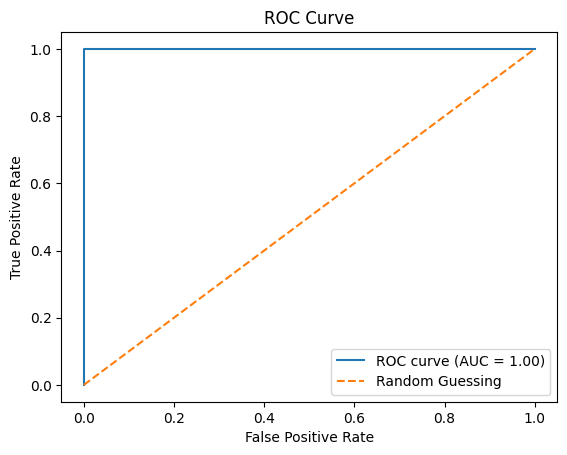

In [16]:
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()